# Fleet Clustering - Taiwan FOC

### Update by Jaeyoon Park, 2022-01-14

## Taiwan FOC clustering and others vessels 

We cluster vessel using HDBSCAN and a custom metric to derive fleets
that are related in the sense that they spend a lot of time in the same
location while at sea.

## See Also

* Other notebooks in https://github.com/GlobalFishingWatch/fleet-clustering for 
examples of clustering Squid Jiggers, etc.

In [1]:
from __future__ import print_function
from __future__ import division
from collections import Counter, OrderedDict
import datetime as dt
import hdbscan
import logging
import matplotlib.pyplot as plt
import matplotlib.animation as mpl_animation
import numpy as np
import pandas as pd
from skimage import color
from IPython.display import HTML
from fleet_clustering import bq
from fleet_clustering import filters
from fleet_clustering import distances
from fleet_clustering import animation

/Users/jaeyoon/anaconda3/envs/py37/lib/python3.7/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


## Load the list of Taiwan FOC vessels to BQ
Upload the list of TWN FOC vessels to BQ scratch bucket -- Run it only once

In [101]:
# df = pd.read_excel('./TWN-FOC/Final MMSI list July & Oct.xlsx')
# df.to_gbq('scratch_jaeyoon.twn_foc_final_mmsis', project_id='world-fishing-827', if_exists='replace')

In [3]:
#
# Flatten the list of MMSIs associated with the same vessel into separate rows
#
q = """
#
# Run it only once to create it
#CREATE OR REPLACE TABLE `world-fishing-827.scratch_jaeyoon.twn_foc_final_mmsis_flat` (
#  list_uvi STRING, 
#  mmsi STRING, 
#  shipname STRING, 
#  callsign STRING, 
#  imo STRING, 
#  flag STRING
#) AS
  
  SELECT DISTINCT list_uvi, mmsi, shipname, callsign, CAST(imo AS STRING) AS imo, flag, TRUE AS foc
  FROM (
    SELECT 
      list_uvi, 
      SPLIT (mmsi, ", ") AS mmsi_array, 
      shipname, callsign, imo, flag
    FROM `scratch_jaeyoon.twn_foc_final_mmsis` ) 
  LEFT JOIN UNNEST (mmsi_array) AS mmsi
"""
df_foc = pd.read_gbq(q, project_id='world-fishing-827')

/Users/jaeyoon/anaconda3/envs/py37/lib/python3.7/site-packages/google/auth/_default.py:70: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/Users/jaeyoon/anaconda3/envs/py37/lib/python3.7/site-packages/google/cloud/bigquery/table.py:1563: UserWarning: Dependency google-cloud-bigquery-storage is outdated, please upgrade it to version >= 2.0.0 (version found: 0.0.0).
  warnings.warn(str(exc))


In [4]:
#
# Flatten the list of MMSIs associated with the same vessel into separate rows
#
q = """
SELECT 
  year, 
  ssvid AS mmsi, 
  ais_identity.n_shipname_mostcommon.value AS shipname, 
  ais_identity.n_callsign_mostcommon.value AS callsign,
  best.best_flag AS flag, 
  best.best_vessel_class AS vessel_class
FROM `gfw_research.vi_ssvid_byyear_v20210913`
WHERE best.best_flag = "TWN"
  AND year >= 2019
  AND (on_fishing_list_best 
    OR best.best_vessel_class IN (
      "reefer", "specialized_reefer", "container_reefer", "well_boat", "fish_factory", "fish_tender"))
"""
df_twn = pd.read_gbq(q, project_id='world-fishing-827')

In [5]:
len(df_foc), len(df_twn)

(222, 7189)

## Load AIS Clustering Data

Load the AIS data that we use for clustering. Note that it onlyu includes vessels away
from shores so as to exclude clustering on ports

In [17]:
all_by_date = bq.load_ais_by_date('', dt.date(2020, 1, 1),
                                  dt.date(2021, 12, 31),
                                  fishing_only=False, 
                                  min_km_from_shore=0,
                                  ssvid=tuple(df_foc.mmsi.values) + tuple(df_twn.mmsi.values))   
all_by_date
pruned_by_date = {k : filters.remove_near_shore(10,
                            filters.remove_chinese_coast(v)) for (k, v) in all_by_date.items()}
valid_ssvid = sorted(filters.find_valid_ssvid(pruned_by_date))

2020-01-01


/Users/jaeyoon/anaconda3/envs/py37/lib/python3.7/site-packages/google/cloud/bigquery/table.py:1563: UserWarning: Dependency google-cloud-bigquery-storage is outdated, please upgrade it to version >= 2.0.0 (version found: 0.0.0).
  warnings.warn(str(exc))


2020-07-03
2021-01-03
2021-07-06
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [18]:
len(valid_ssvid)

1198

## Create Distance Metrics

Create an array of distance metrics. The details are still evolving, but in general
we want to deal with two things.  Days on which a boat is missing and days where the
boat is away from the fleet.

* Distances to/from a boat on days when it is missing are represented by $\infty$ in 
  the distance matrix. HDBSCAN ignores these values.
* Only the closest N days are kept for each boat pair, allowing boats to leave the fleet
  for up to half the year without penalty.
  
In addition, distances have a floor of 1 km to prevent overclustering when boats tie up
up together, etc.

In [20]:
dists_by_date = {}
valid_ssvid_by_date = {}

In [21]:
for start_date, end_date in [
    ("20200101", "20201231"),
    ("20210101", "20211231"),
]:
    if start_date in dists_by_date:
        continue
    print("computing distance for", start_date, end_date)
    subset_by_date = {
        k: v for (k, v) in pruned_by_date.items() if start_date <= k <= end_date
    }
    valid_ssvid_by_date[start_date] = sorted(filters.find_valid_ssvid(subset_by_date))
    C = distances.create_composite_lonlat_array(
        subset_by_date, valid_ssvid_by_date[start_date]
    )
    dists = distances.compute_distances_4(C, gamma=2)
    dists_by_date[start_date] = dists

computing distance for 20200101 20201231
computing distance for 20210101 20211231


## Load Carrier Data (not used currently)

In [53]:
# carriers_by_date = bq.load_carriers_by_year(2019, 2020)
# pruned_carriers_by_date = {k : filters.remove_chinese_coast(v) for (k, v) in carriers_by_date.items()}
# # query = """
# #                SELECT CAST(mmsi AS STRING) FROM
# #                `world-fishing-827.vessel_database.all_vessels_20190102`
# #                WHERE  iscarriervessel AND confidence = 3
# #         """
# query = """
#   SELECT DISTINCT CAST (mmsi AS STRING) AS mmsi
#   FROM `world-fishing-827.vessel_database.carrier_vessels_byyear_v20211201`
#   WHERE year = 2019
# """
# valid_carrier_ssvid_df = pd.read_gbq(query, dialect='standard', project_id='world-fishing-827')
# valid_carrier_ssvid = valid_carrier_ssvid_df.mmsi
# valid_carrier_ssvid_set = set(valid_carrier_ssvid)

/Users/jaeyoon/anaconda3/envs/py37/lib/python3.7/site-packages/google/cloud/bigquery/table.py:1563: UserWarning: Dependency google-cloud-bigquery-storage is outdated, please upgrade it to version >= 2.0.0 (version found: 0.0.0).
  warnings.warn(str(exc))
/Users/jaeyoon/anaconda3/envs/py37/lib/python3.7/site-packages/google/cloud/bigquery/table.py:1563: UserWarning: Dependency google-cloud-bigquery-storage is outdated, please upgrade it to version >= 2.0.0 (version found: 0.0.0).
  warnings.warn(str(exc))


## Load Encounters Data And Country Codes (not used currently)

This is used to filter the carrier vessels down to only those
that meet with target vessels and to add iso3 labels to outputs

In [60]:
# encounters = bq.load_carriers(2019, 2019)

/Users/jaeyoon/anaconda3/envs/py37/lib/python3.7/site-packages/google/cloud/bigquery/table.py:1563: UserWarning: Dependency google-cloud-bigquery-storage is outdated, please upgrade it to version >= 2.0.0 (version found: 0.0.0).
  warnings.warn(str(exc))


In [99]:
query = """
SELECT code, iso3 FROM `world-fishing-827.gfw_research.country_codes`"""
country_codes_df = pd.read_gbq(query, dialect='standard', project_id='world-fishing-827')
iso3_map = {x.code : x.iso3 for x in country_codes_df.itertuples()}

## Fit the Clusterer

This is pretty straightforward -- all the complicated stuff is
embedded in the matrix computations. Fleet size can be tweaked
using `min_cluster_size` and `min_sample_size`.

In [22]:
raw_clusterers = {}
for start_date, dists in dists_by_date.items():
    clusterer = hdbscan.HDBSCAN(metric='precomputed', 
                                min_cluster_size=5,
                               )
    clusterer.fit(dists)
    raw_clusterers[start_date] = clusterer

## Set up Fleets

Set up the fleets for viewing.

In [25]:
#
# As we process the clustering with vessels including both Taiwanese FOC and Taiwanese flagged,
# there would be clusters that uniquely contain Taiwanese flagged vessels.
# We are interested in clusters that have at least some FOC vessels, which means
# we should remove those clusters only with Taiwanese flagged ones.
def select_fleets_with_foc(joint_ssvid, labels):
    gr = pd.DataFrame({'mmsi': joint_ssvid, 'label': labels})
    gr['mmsi'] = gr['mmsi'].astype(str)
    gr = gr.merge(df_foc[['mmsi', 'foc']], how='left', on='mmsi')
    gr['foc'] = gr['foc'].apply(lambda x: True if x == x and x is not None and x else False)
    flt = gr.groupby('label')['foc'].agg(any)
    no_flt_twn = gr[(gr.label == -1) & (gr.foc == False)].mmsi.values
    
    flt_ssvid, flt_labels = [], []
    for s, l in zip(joint_ssvid, labels):
        if l in flt[flt].index.values and s not in no_flt_twn:
            flt_ssvid.append(s)
            flt_labels.append(l)
            
    return flt_ssvid, flt_labels

In [90]:
def to_rgb(string):
    string = string.strip('#')
    r = string[:2]
    g = string[2:4]
    b = string[4:]
    return [int(x, 16) / 225.0 for x in (r, g, b)]


def find_labels(dists, valid_ssvid):
    clusterer = hdbscan.HDBSCAN(metric='precomputed', 
                                min_cluster_size=5).fit(dists)
    
#     all_fleet_ssvid_set = set([s for (s, f) in zip(valid_ssvid, clusterer.labels_) if f >= 0])
#     valid_ssvid_set = set(valid_ssvid)
#     all_fleet_reefer_ssvid_set = set()
#     for x in encounters.itertuples():
#         if x.ssvid_1 in all_fleet_ssvid_set and x.ssvid_2 in valid_carrier_ssvid_set:
#             all_fleet_reefer_ssvid_set.add(x.ssvid_2)
#         if x.ssvid_2 in all_fleet_ssvid_set and x.ssvid_1 in valid_carrier_ssvid_set:
#             all_fleet_reefer_ssvid_set.add(x.ssvid_1)
#     all_fleet_reefer_ssvid = sorted(all_fleet_reefer_ssvid_set)

#     valid_ssvid_set = set(valid_ssvid)
#     carrier_ids = [x for x in all_fleet_reefer_ssvid if x not in valid_ssvid_set]
#     focs = df_foc.mmsi.values
    joint_ssvid = valid_ssvid #+ sorted(focs)#+ sorted(carrier_ids) 
    labels = list(clusterer.labels_) #+ [max(clusterer.labels_) + 1] * len(focs) #+ [max(clusterer.labels_) + 1] * len(carrier_ids) 

    # Remove vessels that have no connection to other vessels
    for i, ssvid in enumerate(valid_ssvid):
        connections = (~np.isinf(dists[i])).sum()
        if connections == 0:
            labels[i] = -1
            
    return joint_ssvid, labels


def create_fleet_mapping(labels, mark_foc=False):
    counts = []
    skip = []
    for i in range(max(labels) + 1):
        if i in skip:
            counts.append(0)
        else:
            counts.append((np.array(labels) == i).sum())

    fleet_ids = [x for x in np.argsort(counts)[::-1] if counts[x] > 0]
#     fleet_ids_without_carriers = [x for x in fleet_ids if x != max(labels)]

    fleets = OrderedDict()
    n_hues = int(np.ceil(len(fleet_ids) / 2.0)) #4.0))
    used = set()
    for i, fid in enumerate(fleet_ids): #_without_carriers):
        b = (i // (2 * (n_hues))) % 2
        c = (i)% (n_hues)
        d = i  % 4 #2
        print(b,c,d)
        symbol = 'osd^v'[d]#'H^sX'[d]
        assert (b, c, d) not in used, (i, b, c, d)
        used.add((b, c, d))
        sat = 1
        val = 1
        raw_hue = c / float(n_hues)
        # We remap the raw hue in order to avoid the 60 degree segment around blue
        hue = 5. / 6. * raw_hue
        if hue > 7. / 12.:
            hue += 1. / 6.
        assert 0 <= hue < 1, hue
        [[clr]] = color.hsv2rgb([[(hue, sat, val)]])
        fg = [[0.1511111111111111, 0.2, 0.3333333333333333], clr][b]
        bg = [clr, [0.1511111111111111, 0.2, 0.3333333333333333]][b]
        w = [1, 2][b]
        sz = [9, 7][b]
        fleets[fid] = (symbol, tuple(fg), tuple(bg), sz, w,  str(i + 1))

#     if mark_foc:
#         fleets[max(labels)] = ('.', 'w', 'w', 8, 2, 'FOC')
        
    print(len(set([x for x in fleets if x != -1])), "fleets")
    return fleets
    

0 0 0
0 1 1
0 2 2
0 3 3
0 0 4
0 1 0
0 2 1
0 3 2
8 fleets


/Users/jaeyoon/gfw/fleet-clustering/fleet_clustering/animation.py:176: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.subplots_adjust(bottom=bottom_adjust, top=top_adjust)
/Users/jaeyoon/anaconda3/envs/py37/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)
/Users/jaeyoon/anaconda3/envs/py37/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


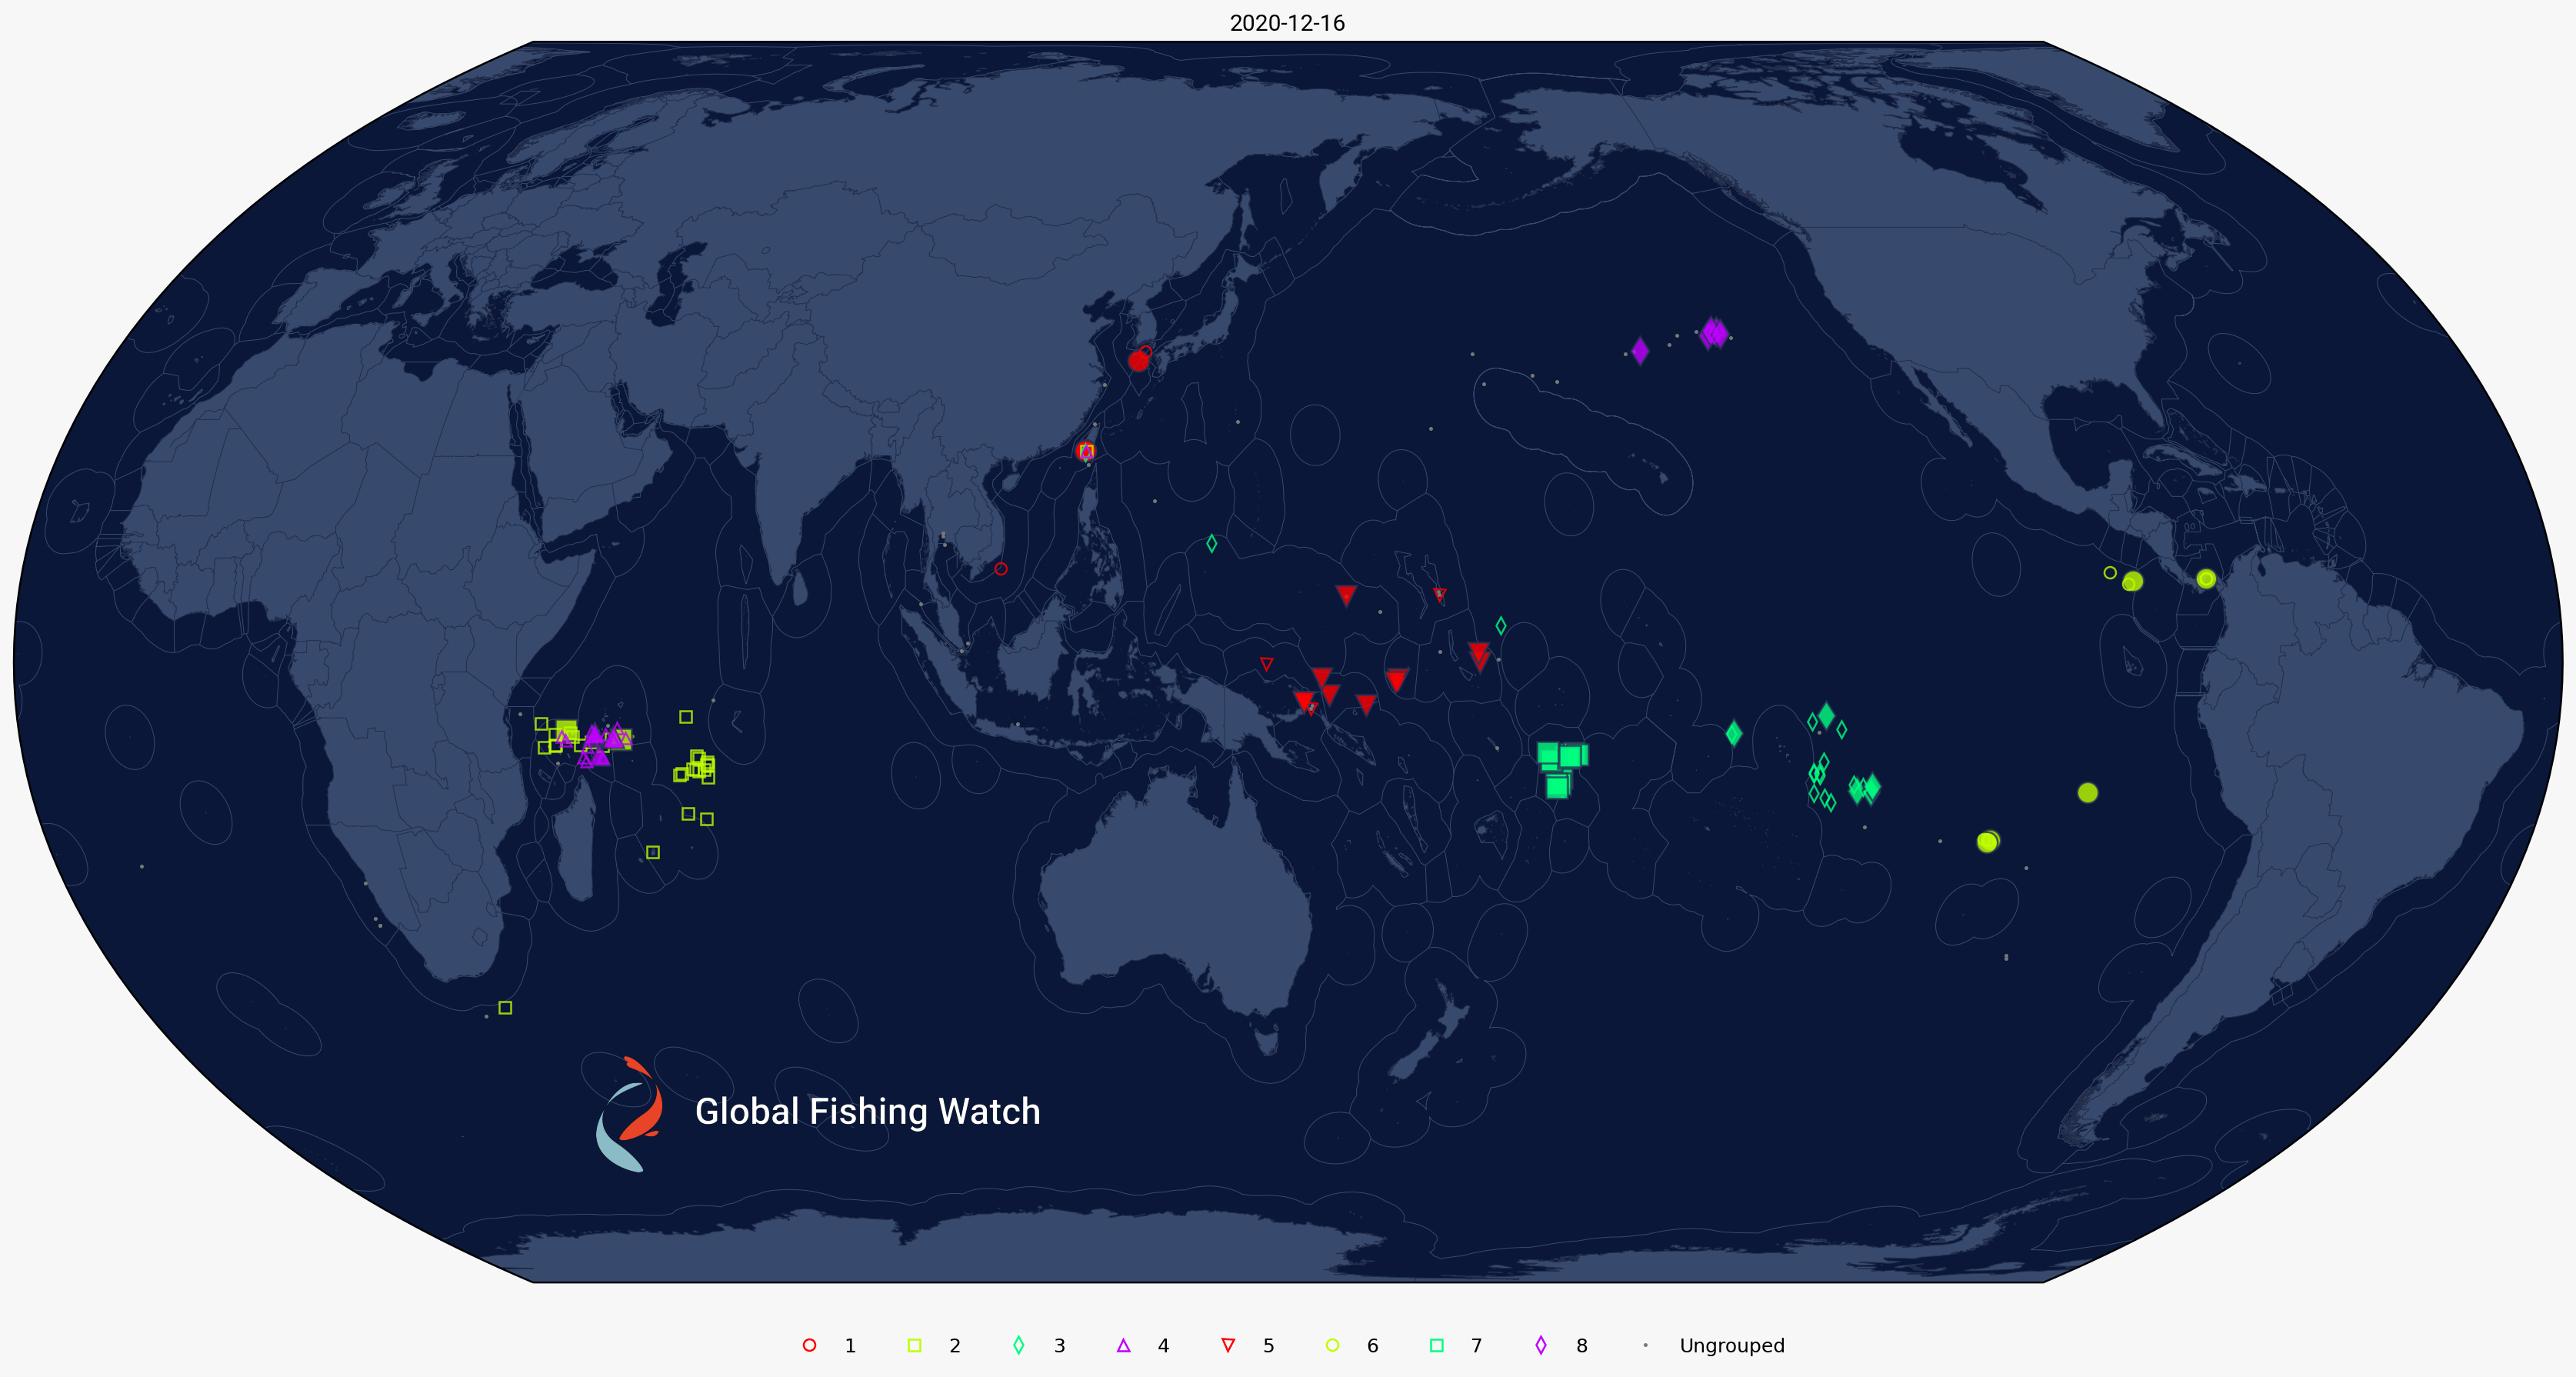

In [89]:
import imp; imp.reload(animation)
start_date = '20200101'
end_date = '20201231'
lst_ssvids, lst_labels = find_labels(dists_by_date[start_date], 
                   valid_ssvid_by_date[start_date])

all_pos_by_date = {k : v for (k, v) in all_by_date.items() if start_date <= k <= end_date}

lst_ssvids, lst_labels = select_fleets_with_foc(lst_ssvids, lst_labels)

fleets = create_fleet_mapping(lst_labels, mark_foc=True)

anim = animation.make_anim(lst_ssvids, 
                           lst_labels, 
                           all_pos_by_date, 
                           interval=10,
                           fleets=fleets, 
                           show_ungrouped=True,
                           alpha=0.8,
                           legend_cols=12,
                           ungrouped_legend="Ungrouped")
HTML(anim.to_html5_video())
# Writer = mpl_animation.writers['ffmpeg']
# writer = Writer(fps=8, metadata=dict(artist='Me'), bitrate=1800)
# anim.save('./TWN_FOC/fleet_clustering_twn_foc_2020.mp4', writer=writer,
#           savefig_kwargs={'facecolor':'#222D4B'})

0 0 0
0 1 1
0 2 2
0 3 3
0 4 0
0 0 1
0 1 2
0 2 3
0 3 0
9 fleets


/Users/jaeyoon/gfw/fleet-clustering/fleet_clustering/animation.py:176: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.subplots_adjust(bottom=bottom_adjust, top=top_adjust)
/Users/jaeyoon/anaconda3/envs/py37/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)
/Users/jaeyoon/anaconda3/envs/py37/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


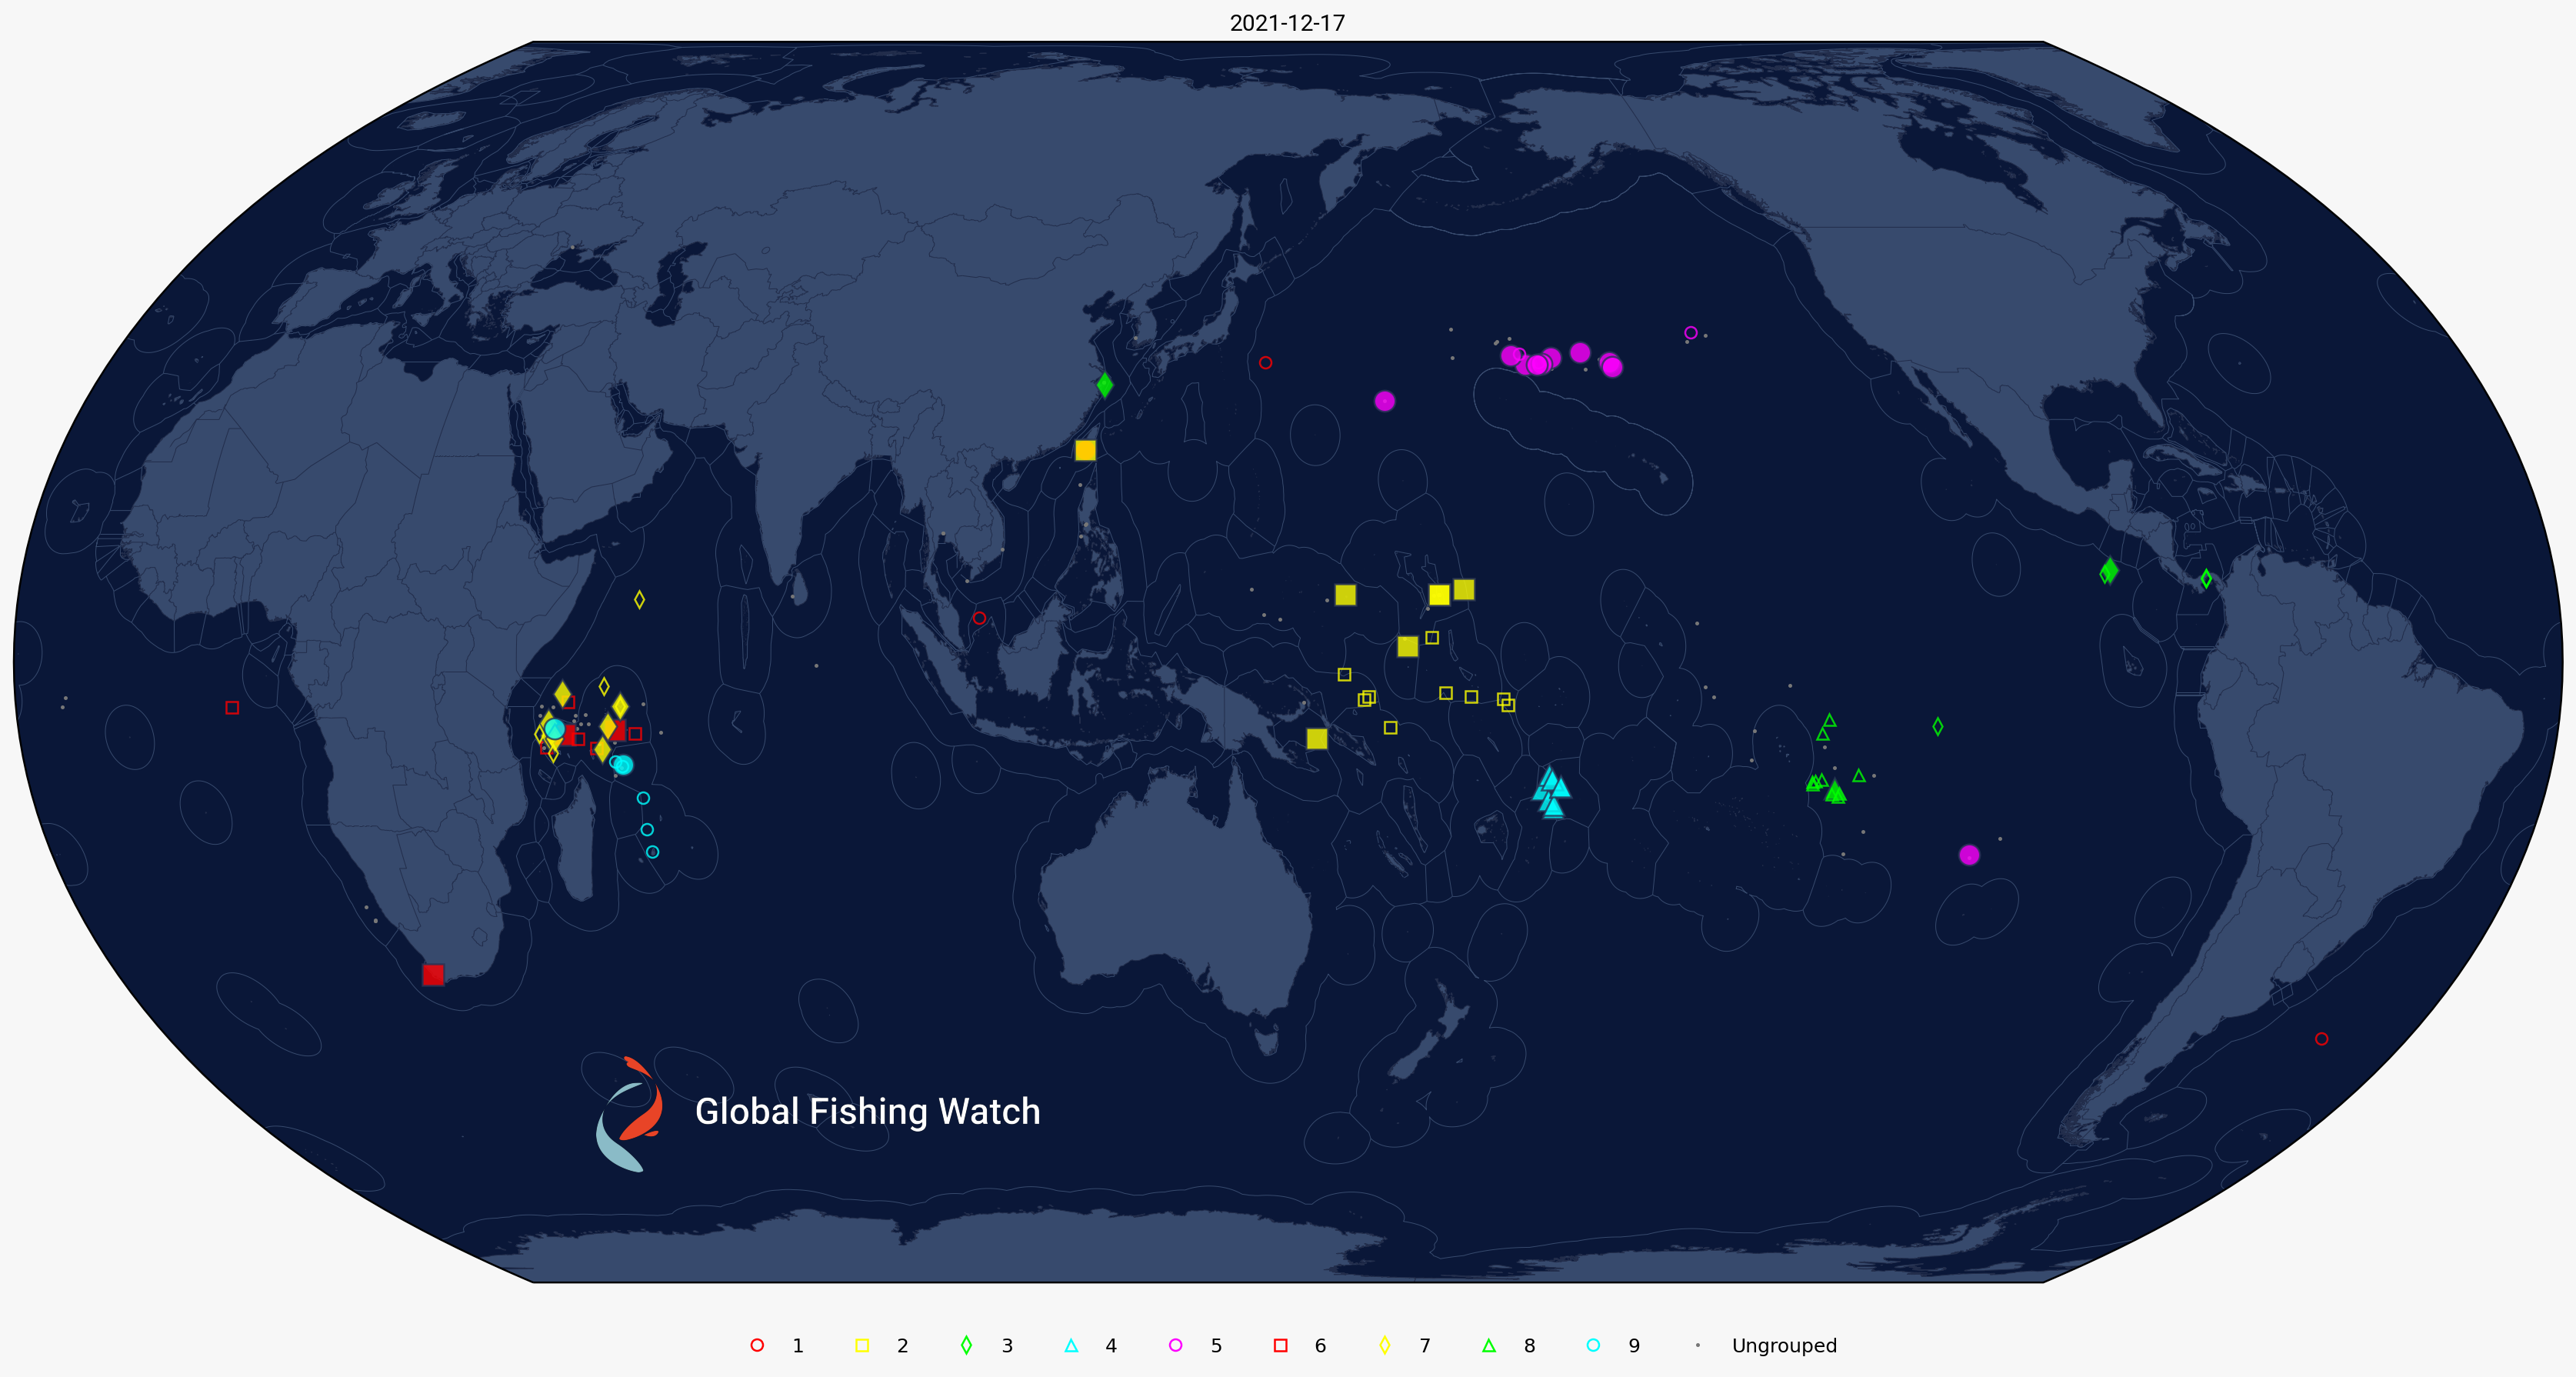

In [91]:
import imp; imp.reload(animation)
start_date = '20210101'
end_date = '20211231'
lst_ssvids, lst_labels = find_labels(dists_by_date[start_date], 
                   valid_ssvid_by_date[start_date])

all_pos_by_date = {k : v for (k, v) in all_by_date.items() if start_date <= k <= end_date}

lst_ssvids, lst_labels = select_fleets_with_foc(lst_ssvids, lst_labels)

fleets = create_fleet_mapping(lst_labels, mark_foc=True)

anim = animation.make_anim(lst_ssvids, 
                           lst_labels, 
                           all_pos_by_date, 
                           interval=10,
                           fleets=fleets, 
                           show_ungrouped=True,
                           alpha=0.8,
                           legend_cols=12,
                           ungrouped_legend="Ungrouped")
HTML(anim.to_html5_video())
# Writer = mpl_animation.writers['ffmpeg']
# writer = Writer(fps=8, metadata=dict(artist='Me'), bitrate=1800)
# anim.save('./TWN_FOC/fleet_clustering_twn_foc_2021.mp4', writer=writer,
#           savefig_kwargs={'facecolor':'#222D4B'})

## Print Out Typical Fleet Membership

In [92]:
def print_fleets(fleets, labels, joint_ssvid):
    for fid, v in fleets.items():
        label = v[-1]
        mask = (fid == np.array(labels))
        ssvids = np.array(joint_ssvid)[mask]
        mids = [x[:3] for x in ssvids]
        countries = [iso3_map.get(float(x), x) for x in mids]
        c = Counter(countries)
        print('Fleet: {} ({})'.format(label, fid), label)
        for country, count in c.most_common():
            print('\t', country, ':', count)

In [100]:
print_fleets(fleets, lst_labels, lst_ssvids)

Fleet: 1 (12) 1
	 TWN : 103
	 VUT : 4
	 RUS : 1
	 LKA : 1
	 KOR : 1
Fleet: 2 (5) 2
	 TWN : 13
	 NRU : 6
	 FSM : 5
	 USA : 3
	 MHL : 3
	 554 : 2
	 SLB : 2
	 TUV : 1
	 VUT : 1
Fleet: 3 (0) 3
	 TWN : 9
	 PAN : 3
	 FJI : 2
	 454 : 1
	 VUT : 1
Fleet: 4 (2) 4
	 VUT : 9
	 COK : 6
Fleet: 5 (7) 5
	 VUT : 11
	 TWN : 3
Fleet: 6 (18) 6
	 TWN : 11
	 SYC : 3
Fleet: 7 (16) 7
	 SYC : 8
	 TWN : 5
Fleet: 8 (6) 8
	 TWN : 10
	 VUT : 1
Fleet: 9 (14) 9
	 TWN : 5
	 SYC : 2
